
## A simple GAN to generate Images


In [1]:

import torch
import numpy as np
import os

from torchvision import datasets
from torchvision import transforms
import torchvision.transforms as T
import torchvision
import matplotlib.pyplot as plt
import pandas as pd

from numpy import genfromtxt

from PIL import Image

import random
import torch.nn.functional as F

In [2]:

import sklearn

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

from mlxtend.plotting import heatmap
from sklearn.model_selection import train_test_split

from mlxtend.plotting import heatmap


In [3]:
#! pip install mlxtend

In [4]:

from torch.utils.data import TensorDataset, DataLoader

import torch.optim as optim 
import torch.nn as nn


import torch.nn.functional as F

from torch.autograd import Variable


In [5]:
if torch.cuda.is_available():
    print("CUDA is available! Running on GPU.")
else:
    print("CUDA is not available. Running on CPU.")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

CUDA is available! Running on GPU.



## Parameters


In [6]:

learning_rate    = 0.003  ## Adam default   ## 0.001
batch_size       = 32
N_Epochs         = 200  ##27000  



## Read the data


In [7]:

data_path = "Z:/530/archive/Dataset"


In [8]:

# Define the transformation to resize the images and convert them to RGB format
transform = transforms.Compose([
    #transforms.Resize((80, 40)),  # Convert RGBA to RGB
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) 
])


In [9]:
# Load the dataset from the local folder
mnist_data = datasets.ImageFolder(root=data_path, transform=transform)
# Split the dataset into train and test
train_size = int(0.8 * len(mnist_data))
test_size = len(mnist_data) - train_size
mnist_train, mnist_test = torch.utils.data.random_split(mnist_data, [train_size, test_size])

In [10]:
# Define batch size
batch_size = 32

train_dl = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
test_dl = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size, shuffle=False)



## View the Images


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


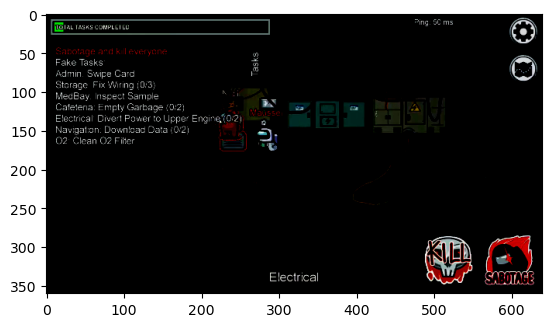

Label: 0


In [11]:

# Iterate over the train_dl DataLoader
for images, labels in train_dl:
    # Take the first image from the batch
    image = images[0]
    
    # Convert the image tensor to numpy array and transpose it to (height, width, channels)
    image = image.permute(1, 2, 0).numpy()
    
    # Display the image
    plt.imshow(image)
    plt.show()
    
    # Display the label
    print("Label:", labels[0].item())
    
    # Break the loop after displaying one image
    break
#Image.fromarray(  mnist_train_tr.data[333].numpy()  ) 


In [12]:

print("Number of images in the training dataset:", len(mnist_train))
# Take the first image from the dataset
first_image, _ = mnist_train[0]

# Print the shape of the first image
print("Shape of the first image:", first_image.shape)

Number of images in the training dataset: 8000
Shape of the first image: torch.Size([3, 360, 640])



## Create Data Loaders


In [13]:

print("Number of images in the test dataset:", len(mnist_test))


Number of images in the test dataset: 2000


In [14]:

train_dl  = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True  )

test_dl   = torch.utils.data.DataLoader(mnist_test,  batch_size=batch_size, shuffle=False )



## Utility Functions


In [15]:

def plot_GAN_losses(list_losses_real, list_losses_fake, list_losses_tricked):
    
    the_epochs = [i for i in range(len(list_losses_real))]  

    plt.plot(the_epochs, list_losses_real,    label = "real") 
    plt.plot(the_epochs, list_losses_fake,    label = "fake") 
    plt.plot(the_epochs, list_losses_tricked, label = "tricked")
    plt.legend() 
    plt.show()


In [16]:

def print_metrics_function(y_test, y_pred):
    print('Accuracy: %.2f' % accuracy_score(y_test, y_pred))
    confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
    print("Confusion Matrix:")
    print(confmat)
    print('Precision: %.3f' % precision_score(y_true=y_test, y_pred=y_pred, average='weighted'))
    print('Recall: %.3f' % recall_score(y_true=y_test, y_pred=y_pred, average='weighted'))
    f1_measure = f1_score(y_true=y_test, y_pred=y_pred, average='weighted')
    print('F1-mesure: %.3f' % f1_measure)
    return f1_measure, confmat


In [17]:

def plot_metric_per_epoch(the_scores_list):
    x_epochs = []
    y_epochs = [] 
    for i, val in enumerate(the_scores_list):
        x_epochs.append(i)
        y_epochs.append(val)
    
    plt.scatter(x_epochs, y_epochs,s=50,c='lightgreen', marker='s', label='score')
    plt.xlabel('epoch')
    plt.ylabel('score')
    plt.title('Score per epoch')
    plt.legend()
    plt.grid()
    plt.show()


In [18]:

def random_G_vector_input():
    rand_vec = torch.randn( 100 )
    return rand_vec


In [19]:

def random_G_batch_vector_input():
    rand_vec = torch.randn(batch_size, 100 ).to(device)
    return rand_vec


In [20]:

def random_batch_one_hot_rc(batch_size, size):
    rand_vec = torch.zeros( (batch_size, size )).to(device)
    for i in range(batch_size):
        random_idx = random.randint(0,size-1)
        rand_vec[i, random_idx] = 1.0
    return rand_vec


In [21]:
'''

# size here must only be an integer
def generate_random_one_hot(size):
    label_tensor = torch.zeros((size))
    random_idx = random.randint(0,size-1)
    label_tensor[random_idx] = 1.0
    return label_tensor
'''



'\n\n# size here must only be an integer\ndef generate_random_one_hot(size):\n    label_tensor = torch.zeros((size))\n    random_idx = random.randint(0,size-1)\n    label_tensor[random_idx] = 1.0\n    return label_tensor\n'

In [22]:

#random_batch_one_hot_rc(32, 10)
 



## NN Architectures


In [23]:

class Generator_Net(nn.Module):
    
    def __init__(self):
        super().__init__()
        

        self.linear1 = nn.Linear(100+10, 256)
        self.act1    = nn.LeakyReLU(0.02)
        self.norm1   = nn.LayerNorm(256)
        self.linear2 = nn.Linear(256, 691200)
        self.act2    = nn.Sigmoid()
        self.dropout = nn.Dropout(0.25)
        

    def forward(self, rand_input, label_tensor ):
        
        #print(rand_input.shape)
        #print(label_tensor.shape)

        inputs = torch.cat( ( rand_input , label_tensor) , dim=1)

        x      = self.linear1( inputs )
        x      = self.act1(x)
        x      = self.norm1(x) 
        x      = self.linear2(x)
        x      = self.act2(x)
        y_pred = x
        #print(y_pred.shape)
        return y_pred


In [24]:

class Generator_DL_Net(nn.Module):
    
    def __init__(self):
        super().__init__()
        

        self.linear1 = nn.Linear(110, 60)
        self.act1    = nn.LeakyReLU(0.02)
        self.norm1   = nn.LayerNorm(60)
        self.linear2 = nn.Linear(60, 120)
        self.act2    = nn.LeakyReLU(0.02)
        self.norm2   = nn.LayerNorm(120)
        self.linear3 = nn.Linear(120, 691200)
        self.act3    = nn.Sigmoid()
        self.dropout = nn.Dropout(0.2)
        

    def forward(self, rand_input ):
        

        x      = self.linear1( rand_input )
        x      = self.act1(x)
        x      = self.norm1(x) 
        x      = self.dropout(x)
        x      = self.linear2(x)
        x      = self.act2(x)
        x      = self.norm2(x) 
        x      = self.dropout(x)
        x      = self.linear3(x)
        x      = self.act3(x)
        
        y_pred = x
        
        return y_pred


In [25]:

class Discriminator_Net(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.linear1 = nn.Linear(691200 + 10, 100)
        self.act1    = nn.ReLU()
        self.linear2 = nn.Linear(100, 50)
        self.act2    = nn.ReLU()
        self.linear3 = nn.Linear(50, 1)
        self.act3    = nn.Sigmoid()             ## nn.Softmax(dim=1)
        self.dropout = nn.Dropout(0.25)
        

    def forward(self, x, label_tensor):
        
        inputs = torch.cat( (x, label_tensor) , dim=1)
        
        x      = self.linear1( inputs )
        x      = self.act1(x)
        x      = self.dropout(x)
        x      = self.linear2(x)
        x      = self.act2(x)
        x      = self.dropout(x)
        x      = self.linear3(x)
        y_pred = self.act3(x)
        
        return y_pred



## Training Function


In [26]:

list_losses_real    = []
list_losses_fake    = []
list_losses_tricked = []
    

def training_loop(  N_Epochs, G_model, D_model, D_loss_fn, G_opt, D_opt   ):
    

    for epoch in range(N_Epochs):
        for xb, yb in train_dl:
            xb, yb = xb.to(device), yb.to(device)
            
            # Reshape xb
            
            xb = xb.view(xb.size(0), -1)
            
            #print("yb", yb.shape)
            #print("xb", xb.shape)
            yb = F.one_hot(yb, num_classes=10)
            #print("yb", yb.shape)
            # Generate random noise for the generator
            rand_vector = random_G_batch_vector_input().to(device)
            #print("rand vector", rand_vector.shape)
            # Generate random one-hot labels for the generator
            rand_labels = random_batch_one_hot_rc(batch_size, 10).to(device)
            #print("rand labels", rand_labels.shape)
            # Train Discriminator with real data
            D_real_y_pred = D_model(xb, yb)
            D_real_loss = D_loss_fn(D_real_y_pred, torch.ones((batch_size, 1)).to(device))
            D_opt.zero_grad()
            D_real_loss.backward()
            D_opt.step()

            # Generate fake images
            gen_img = G_model(rand_vector, rand_labels).detach()
            #print(gen_img.shape)
            #print(rand_labels.shape)
            # Train Discriminator with fake data
            D_fake_y_pred = D_model(gen_img, rand_labels)
            D_fake_loss = D_loss_fn(D_fake_y_pred, torch.zeros((batch_size, 1)).to(device))
            D_opt.zero_grad()
            D_fake_loss.backward()
            D_opt.step()
            gen_img = G_model(rand_vector, rand_labels)
            # Train Generator
            D_tricked_y_pred = D_model(gen_img, rand_labels)
            D_tricked_loss = D_loss_fn(D_tricked_y_pred, torch.ones((batch_size, 1)).to(device))
            G_opt.zero_grad()
            D_tricked_loss.backward()
            G_opt.step()

        if epoch % 20 == 0:
            print("******************************")
            print(epoch, "D_real_loss=", D_real_loss.item())
            print(epoch, "D_fake_loss=", D_fake_loss.item())
            print(epoch, "D_tricked_loss=", D_tricked_loss.item())
            list_losses_real.append(        D_real_loss.cpu().detach().numpy()  )
            list_losses_fake.append(        D_fake_loss.cpu().detach().numpy()  )
            list_losses_tricked.append(  D_tricked_loss.cpu().detach().numpy()  )
            # Generate and print fake images
            gen_img = G_model(rand_vector, rand_labels)
            img_grid = torchvision.utils.make_grid(gen_img.cpu().detach(), nrow=8, normalize=True)
            plt.imshow(img_grid.permute(1, 2, 0))
            plt.show()
      


## Call the core functions


******************************
0 D_real_loss= 3.125
0 D_fake_loss= 0.0
0 D_tricked_loss= 100.0


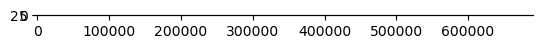

******************************
20 D_real_loss= 0.0
20 D_fake_loss= 100.0
20 D_tricked_loss= 0.0


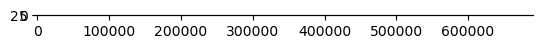

******************************
40 D_real_loss= 6.25
40 D_fake_loss= 53.125
40 D_tricked_loss= 43.75


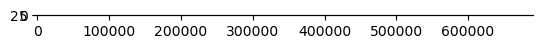

******************************
60 D_real_loss= 9.375
60 D_fake_loss= 21.875
60 D_tricked_loss= 75.0


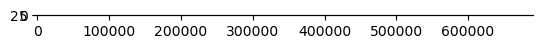

******************************
80 D_real_loss= 6.25
80 D_fake_loss= 56.25
80 D_tricked_loss= 53.125


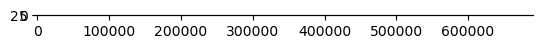

******************************
100 D_real_loss= 9.375
100 D_fake_loss= 0.0
100 D_tricked_loss= 100.0


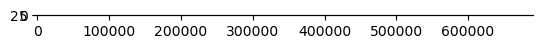

******************************
120 D_real_loss= 6.25
120 D_fake_loss= 0.0
120 D_tricked_loss= 100.0


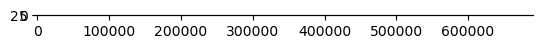

******************************
140 D_real_loss= 0.0
140 D_fake_loss= 3.125
140 D_tricked_loss= 96.875


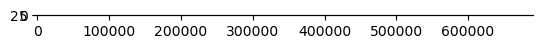

******************************
160 D_real_loss= 9.375
160 D_fake_loss= 0.0
160 D_tricked_loss= 100.0


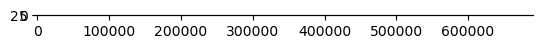

******************************
180 D_real_loss= 3.125
180 D_fake_loss= 0.0
180 D_tricked_loss= 87.5


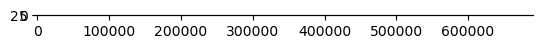

In [27]:

G_model     = Generator_Net().to(device)

## G_model     = Generator_DL_Net()

D_model     = Discriminator_Net().to(device)

## D_loss_fn   = nn.CrossEntropyLoss( )  
## D_loss_fn   = F.mse_loss

D_loss_fn   = nn.BCELoss()

G_opt       = torch.optim.Adam( G_model.parameters(), lr=learning_rate )
D_opt       = torch.optim.Adam( D_model.parameters(), lr=learning_rate )

training_loop(  N_Epochs, G_model, D_model, D_loss_fn, G_opt, D_opt )


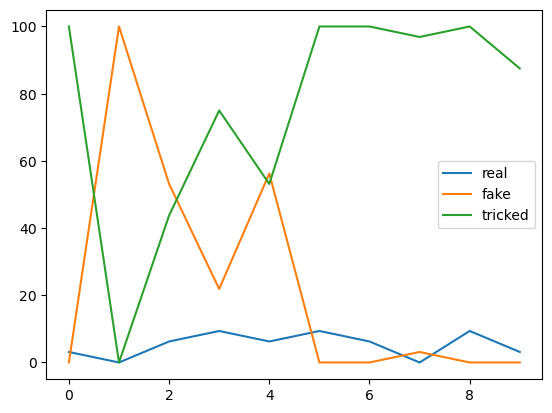

In [28]:

plot_GAN_losses(list_losses_real, list_losses_fake, list_losses_tricked)



## Test generating after training



## Inference CGAN


In [29]:

label = 9
        
label_tensor = torch.zeros((10))
label_tensor[label] = 1.0

        
label_tensor = label_tensor.unsqueeze(0)
label_tensor.shape
label_tensor.to(device)


tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]], device='cuda:0')

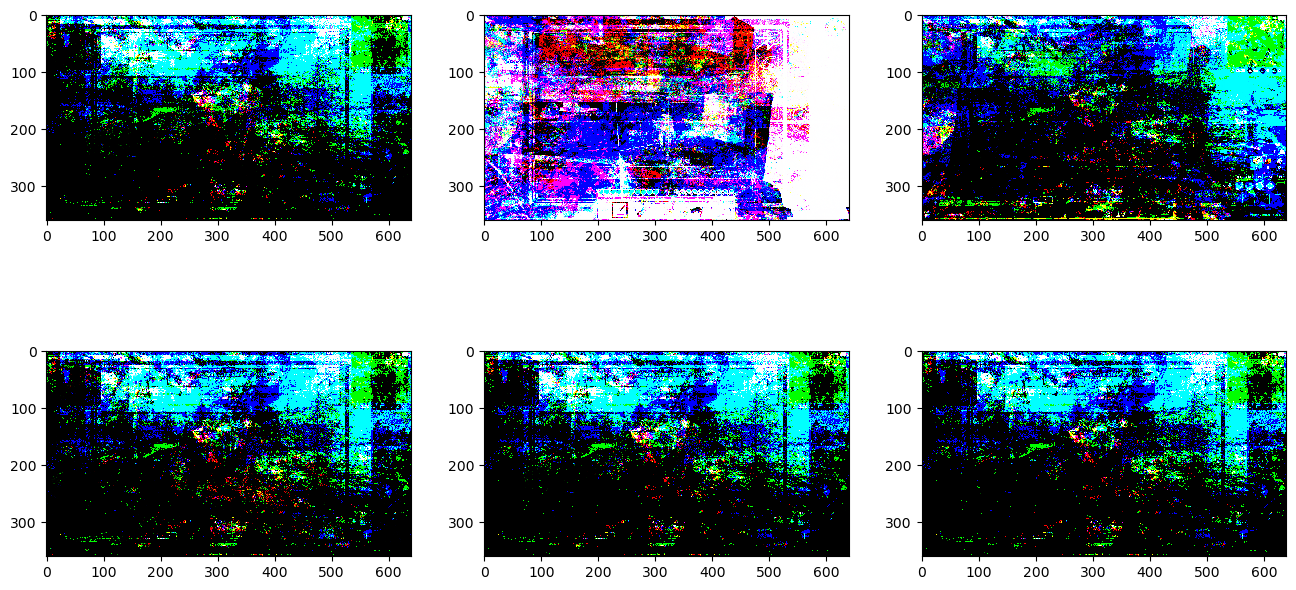

In [30]:

f, axarr = plt.subplots(2,3, figsize=(16,8))

for i in range(2):
    for j in range(3):
        output = G_model.forward( random_G_vector_input().unsqueeze(0).to(device), label_tensor.to(device))
        img = output.detach().cpu().numpy().reshape(3, 360, 640).transpose(1, 2, 0)
        axarr[i,j].imshow(img, interpolation='none')

      


tensor([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]])
tensor([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]])
tensor([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]])
tensor([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]])
tensor([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]])
tensor([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]])


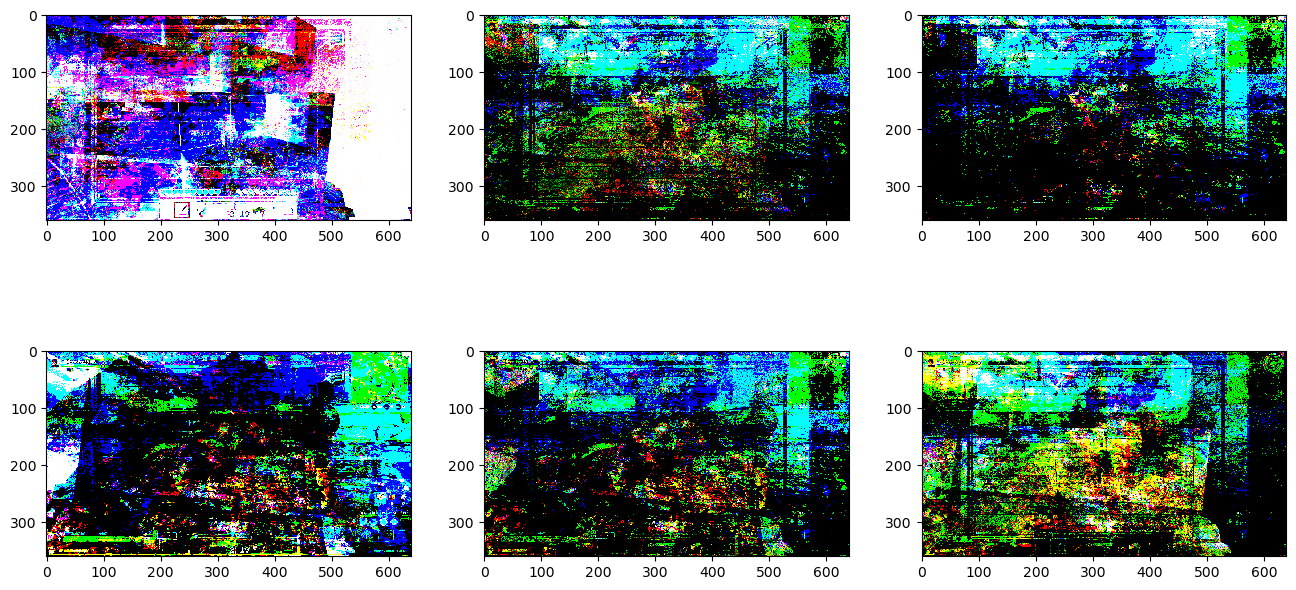

In [40]:

label = 3
        
label_tensor = torch.zeros((10))
label_tensor[label] = 1.0

        
label_tensor = label_tensor.unsqueeze(0)

f, axarr = plt.subplots(2,3, figsize=(16,8))

for i in range(2):
    for j in range(3):
        output = G_model.forward( random_G_vector_input().unsqueeze(0).to(device), label_tensor.to(device))
        img = output.detach().cpu().numpy().reshape(3, 360, 640).transpose(1, 2, 0)
        axarr[i,j].imshow(img, interpolation='none')
        print(label_tensor)

    


tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]])
tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]])
tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]])
tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]])
tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]])
tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]])


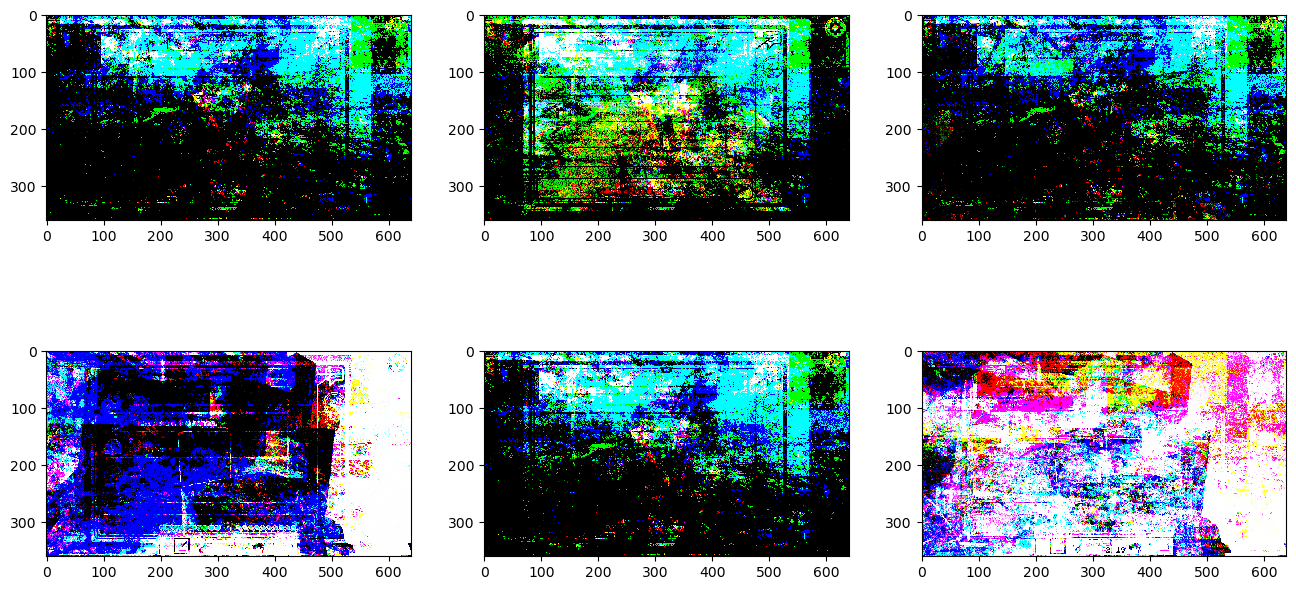

In [41]:


label = 1
        
label_tensor = torch.zeros((10))
label_tensor[label] = 1.0

        
label_tensor = label_tensor.unsqueeze(0)

f, axarr = plt.subplots(2,3, figsize=(16,8))

for i in range(2):
    for j in range(3):
        output = G_model.forward( random_G_vector_input().unsqueeze(0).to(device), label_tensor.to(device))
        img = output.detach().cpu().numpy().reshape(3, 360, 640).transpose(1, 2, 0)
        axarr[i,j].imshow(img, interpolation='none')
        print(label_tensor)


      


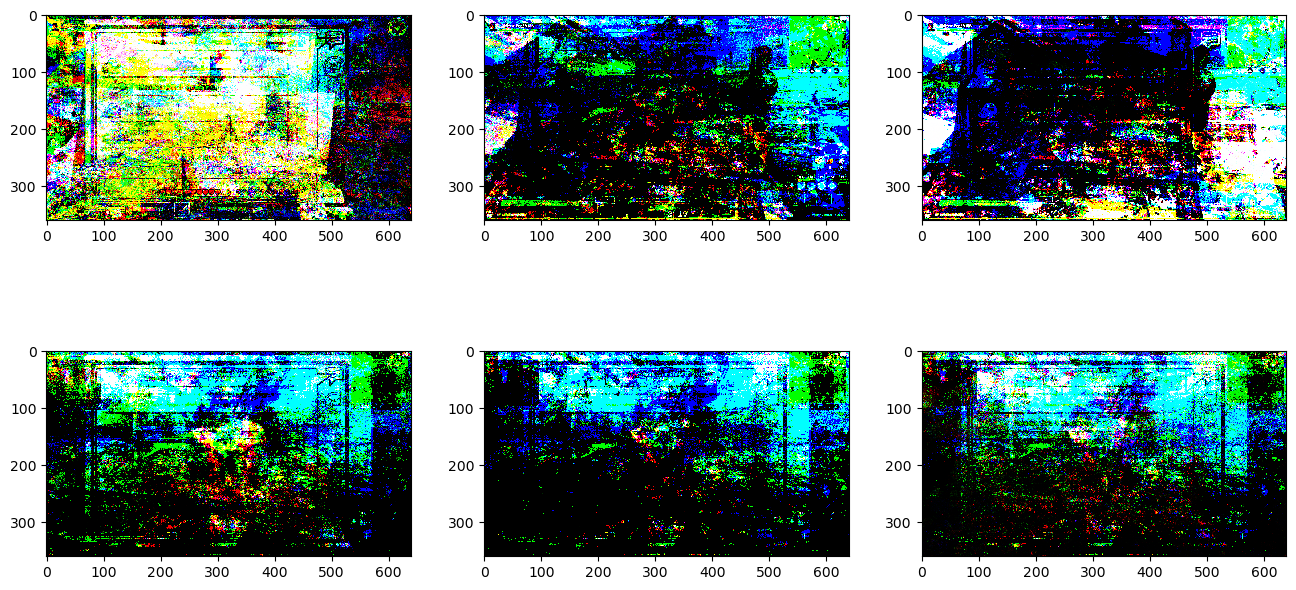

In [33]:


label = 2
        
label_tensor = torch.zeros((10))
label_tensor[label] = 1.0

        
label_tensor = label_tensor.unsqueeze(0)

f, axarr = plt.subplots(2,3, figsize=(16,8))

for i in range(2):
    for j in range(3):
        output = G_model.forward( random_G_vector_input().unsqueeze(0).to(device), label_tensor.to(device))
        img = output.detach().cpu().numpy().reshape(3, 360, 640).transpose(1, 2, 0)
        axarr[i,j].imshow(img, interpolation='none')


      


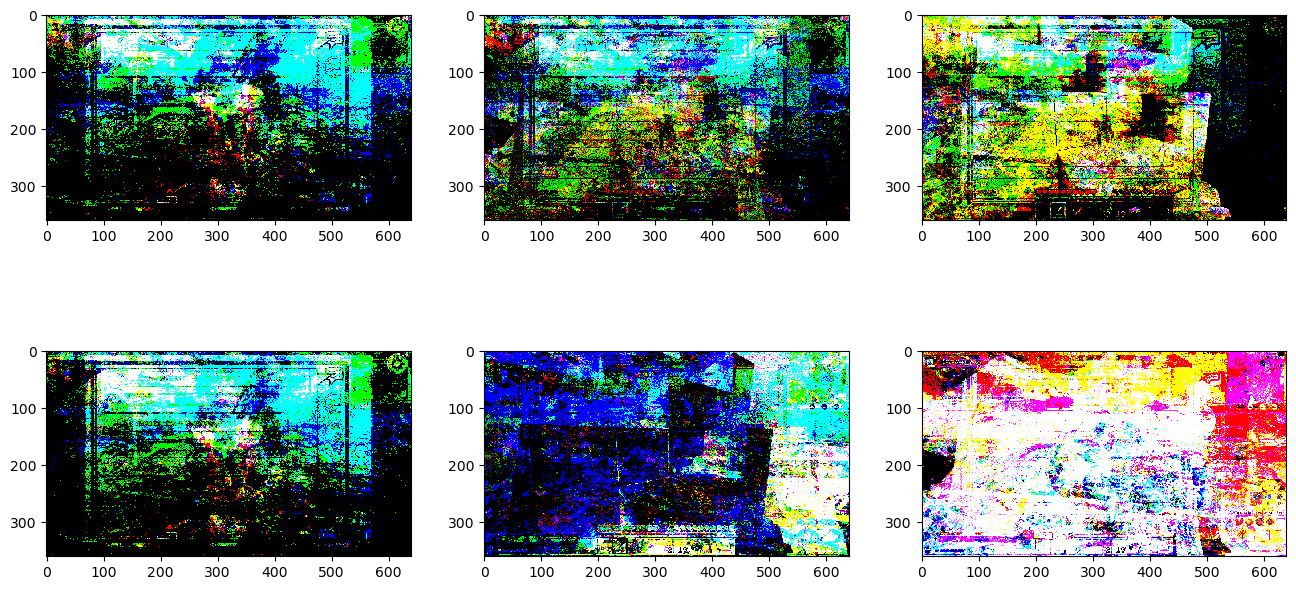

In [34]:


label = 4
        
label_tensor = torch.zeros((10))
label_tensor[label] = 1.0

        
label_tensor = label_tensor.unsqueeze(0)

f, axarr = plt.subplots(2,3, figsize=(16,8))

for i in range(2):
    for j in range(3):
        output = G_model.forward( random_G_vector_input().unsqueeze(0).to(device), label_tensor.to(device))
        img = output.detach().cpu().numpy().reshape(3, 360, 640).transpose(1, 2, 0)
        axarr[i,j].imshow(img, interpolation='none')


      


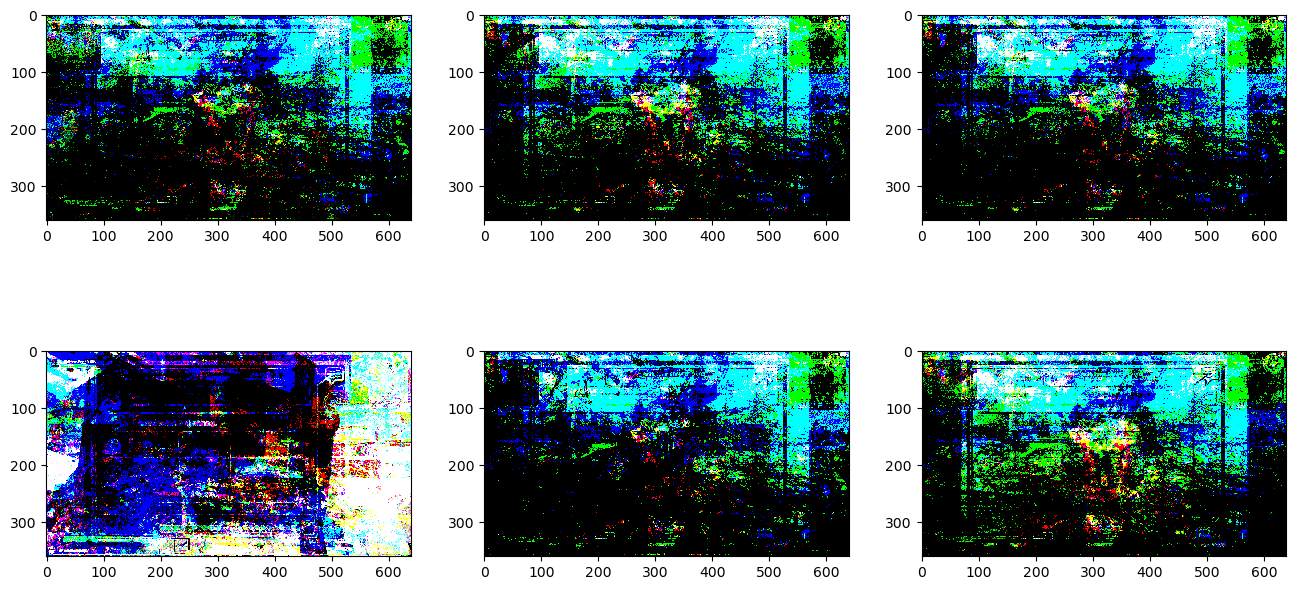

In [35]:


label = 5
        
label_tensor = torch.zeros((10))
label_tensor[label] = 1.0

        
label_tensor = label_tensor.unsqueeze(0)

f, axarr = plt.subplots(2,3, figsize=(16,8))

for i in range(2):
    for j in range(3):
        output = G_model.forward( random_G_vector_input().unsqueeze(0).to(device), label_tensor.to(device))
        img = output.detach().cpu().numpy().reshape(3, 360, 640).transpose(1, 2, 0)
        axarr[i,j].imshow(img, interpolation='none')


      


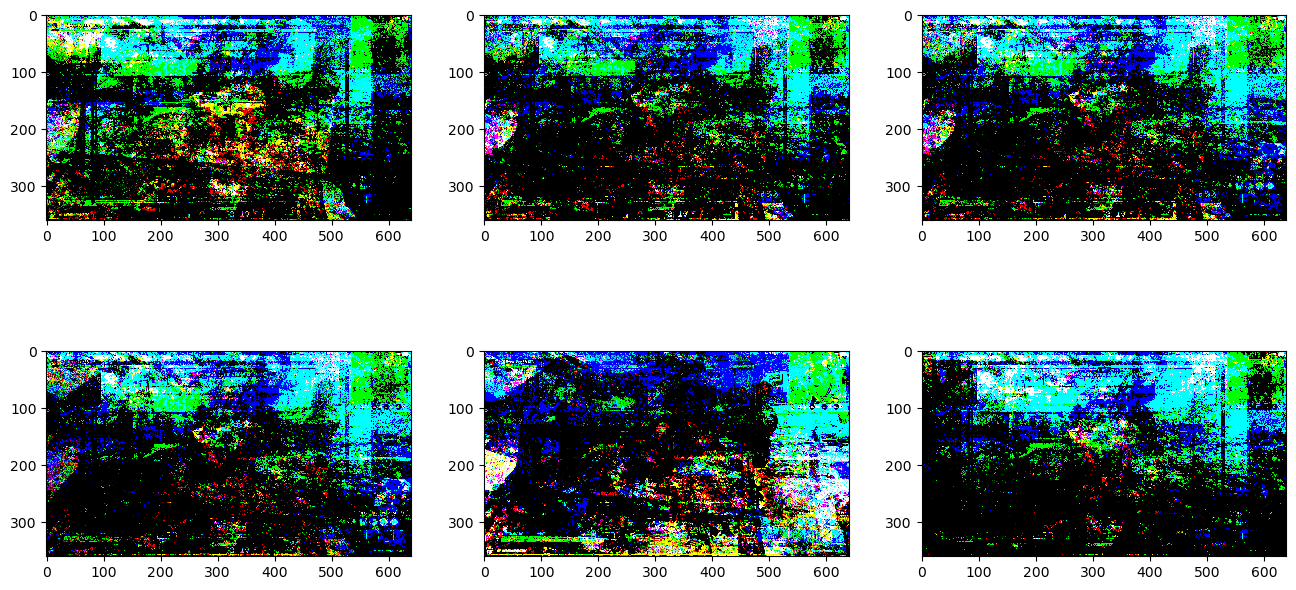

In [36]:


label = 6
        
label_tensor = torch.zeros((10))
label_tensor[label] = 1.0

        
label_tensor = label_tensor.unsqueeze(0)

f, axarr = plt.subplots(2,3, figsize=(16,8))

for i in range(2):
    for j in range(3):
        output = G_model.forward( random_G_vector_input().unsqueeze(0).to(device), label_tensor.to(device))
        img = output.detach().cpu().numpy().reshape(3, 360, 640).transpose(1, 2, 0)
        axarr[i,j].imshow(img, interpolation='none')


      


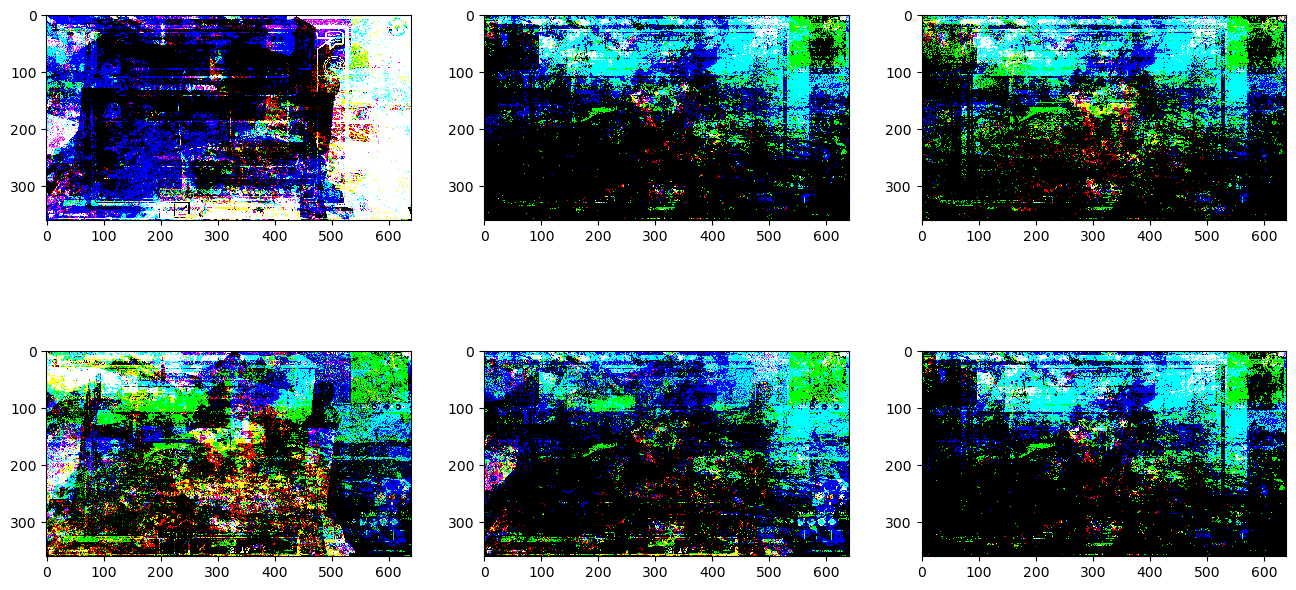

In [37]:


label = 7
        
label_tensor = torch.zeros((10))
label_tensor[label] = 1.0

        
label_tensor = label_tensor.unsqueeze(0)

f, axarr = plt.subplots(2,3, figsize=(16,8))

for i in range(2):
    for j in range(3):
        output = G_model.forward( random_G_vector_input().unsqueeze(0).to(device), label_tensor.to(device))
        img = output.detach().cpu().numpy().reshape(3, 360, 640).transpose(1, 2, 0)
        axarr[i,j].imshow(img, interpolation='none')


      


tensor([[0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]])


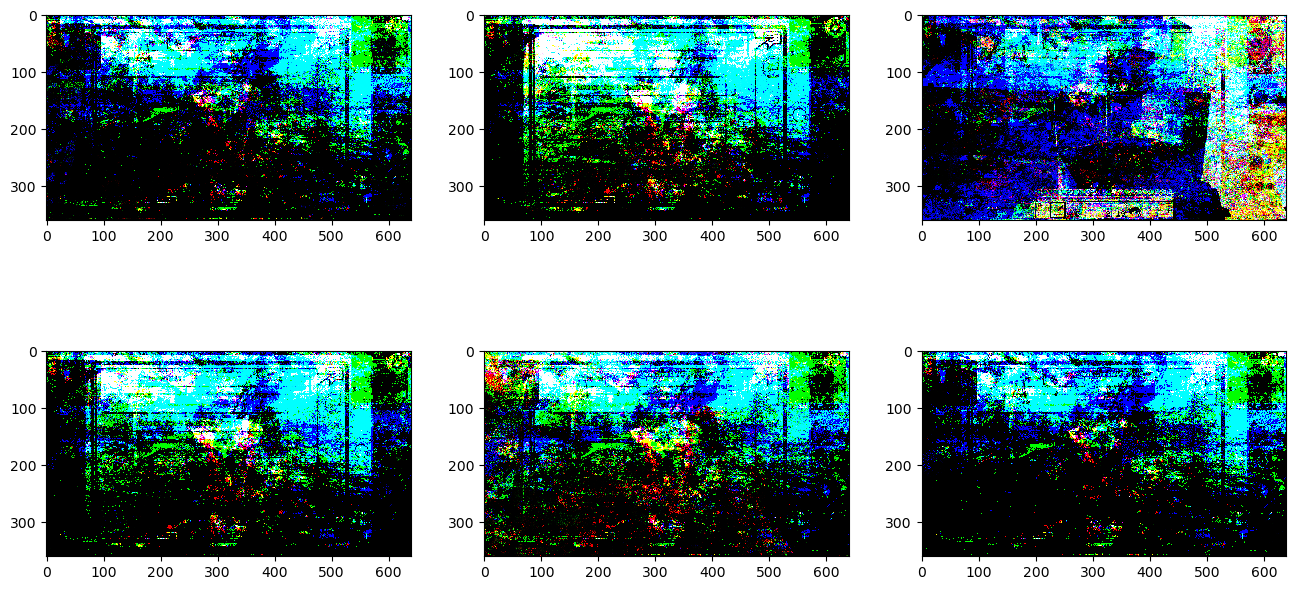

In [38]:


label = 8
        
label_tensor = torch.zeros((10))
label_tensor[label] = 1.0

        
label_tensor = label_tensor.unsqueeze(0)
print(label_tensor)

f, axarr = plt.subplots(2,3, figsize=(16,8))

for i in range(2):
    for j in range(3):
        output = G_model.forward( random_G_vector_input().unsqueeze(0).to(device), label_tensor.to(device))
        img = output.detach().cpu().numpy().reshape(3, 360, 640).transpose(1, 2, 0)
        axarr[i,j].imshow(img, interpolation='none')


      


tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])


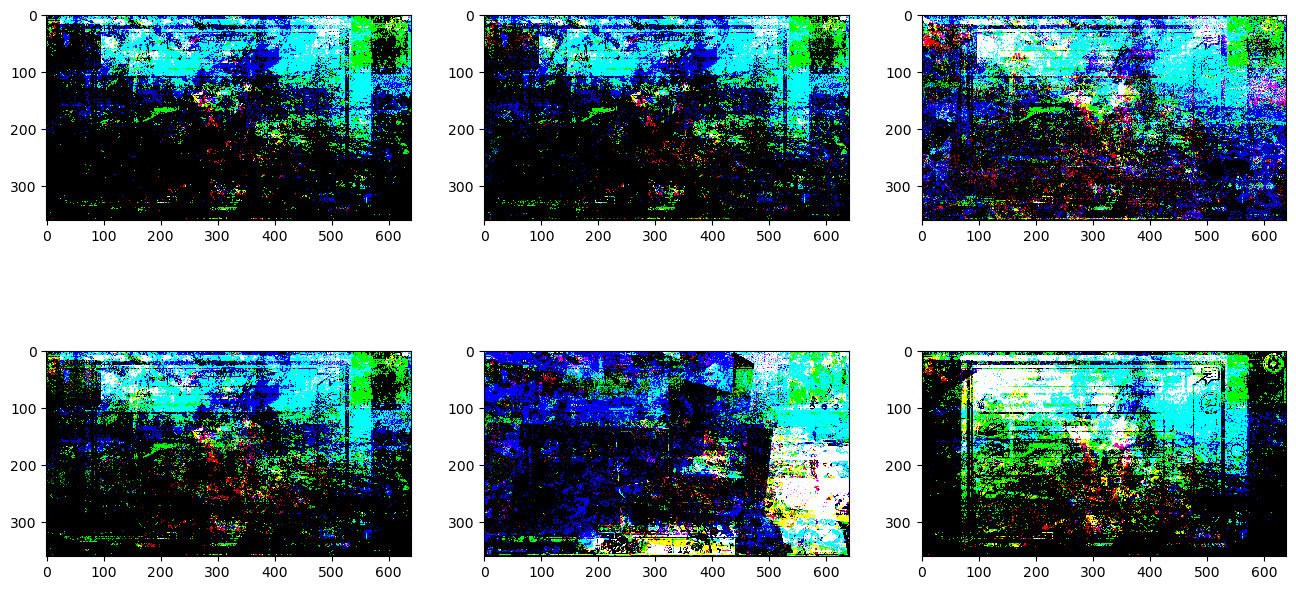

In [39]:


label = 9
        
label_tensor = torch.zeros((10))
label_tensor[label] = 1.0

        
label_tensor = label_tensor.unsqueeze(0)
print(label_tensor)

f, axarr = plt.subplots(2,3, figsize=(16,8))

for i in range(2):
    for j in range(3):
        output = G_model.forward( random_G_vector_input().unsqueeze(0).to(device), label_tensor.to(device))
        img = output.detach().cpu().numpy().reshape(3, 360, 640).transpose(1, 2, 0)
        axarr[i,j].imshow(img, interpolation='none')


      
